In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.optimizers import Adam
import joblib
import pickle

# Load Test Data

In [2]:
# Inputs for TF-IDF trained models
data = pd.read_csv('data/fulltext_preprocessed_data.csv')
style_df = pd.read_csv('data/style_features.csv').drop(columns='label')
X = data['full_text_lemmatized'].astype(str)
y = data['label']

X_train_text, X_test_text, _, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test_style = style_df.loc[X_test_text.index].values

tfidf = joblib.load('artifacts/tfidf_vectorizer.pkl')
X_test_tfidf = tfidf.transform(X_test_text)

scaler = joblib.load('artifacts/scaler.pkl')
X_test_style_scaled = scaler.transform(X_test_style)

X_test_combined_scaled = hstack([X_test_tfidf, X_test_style_scaled])

In [3]:
# Inputs for Word Embeddings trained models
with open('artifacts/pretrained_embeddings_inputs.pkl', 'rb') as f:
    loaded_input_items = pickle.load(f)
X_test_pad = loaded_input_items['X_test_pad']
y_test = loaded_input_items['y_test']

# Load Models

In [4]:
# dictionary of model names and saved model paths
model_paths = {
    'Baseline (TF-IDF + custom stylometric)': 'fake_news_baseline_classifier.pkl',
    'ANN (TF-IDF + custom stylometric)': 'tfidf_ann.keras',
    'Tuned CNN (custom Word2Vec embeddings)': 'tuned_cnn.keras',
    'LSTM (custom Word2Vec embeddings)': 'simple_lstm.keras',
    'GRU (custom Word2Vec embeddings)': 'simple_gru.keras',
    'CNN (GloVE embeddings)': 'pretrained_cnn.keras',
    'GRU (GloVE embeddings)': 'pretrained_gru.keras'
}

In [5]:
models = {}
for name, path in model_paths.items():
    model_path = 'artifacts/'+path
    print(name, model_path)
    if 'Baseline' in name:
        models[name] = joblib.load(model_path)
    else:
        models[name] = load_model(model_path)
        models[name].compile(optimizer=Adam(learning_rate=0.001), 
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

Baseline (TF-IDF + custom stylometric) artifacts/fake_news_baseline_classifier.pkl
ANN (TF-IDF + custom stylometric) artifacts/tfidf_ann.keras
Tuned CNN (custom Word2Vec embeddings) artifacts/tuned_cnn.keras


C:\Users\aleen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


LSTM (custom Word2Vec embeddings) artifacts/simple_lstm.keras


C:\Users\aleen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


GRU (custom Word2Vec embeddings) artifacts/simple_gru.keras
CNN (GloVE embeddings) artifacts/pretrained_cnn.keras
GRU (GloVE embeddings) artifacts/pretrained_gru.keras


# Plot Model Performances

In [6]:
model_accuracies = {}
for name, model in models.items():
    print(name)
    if 'Baseline' in name:
        y_pred = model.predict(X_test_combined_scaled)
        model_accuracies[name] = accuracy_score(y_test_full, y_pred)
    elif 'ANN' in name:
        model_accuracies[name] = model.evaluate(X_test_combined_scaled, y_test_full, verbose=0)[1]
    else:
        model_accuracies[name] = model.evaluate(X_test_pad, y_test, verbose=0)[1]

Baseline (TF-IDF + custom stylometric)
ANN (TF-IDF + custom stylometric)
Tuned CNN (custom Word2Vec embeddings)
LSTM (custom Word2Vec embeddings)
GRU (custom Word2Vec embeddings)
CNN (GloVE embeddings)
GRU (GloVE embeddings)


In [7]:
print(model_accuracies)

{'Baseline (TF-IDF + custom stylometric)': 0.9652068126520681, 'ANN (TF-IDF + custom stylometric)': 0.954501211643219, 'Tuned CNN (custom Word2Vec embeddings)': 0.9627737402915955, 'LSTM (custom Word2Vec embeddings)': 0.9552311301231384, 'GRU (custom Word2Vec embeddings)': 0.9630170464515686, 'CNN (GloVE embeddings)': 0.9579075574874878, 'GRU (GloVE embeddings)': 0.9479318857192993}


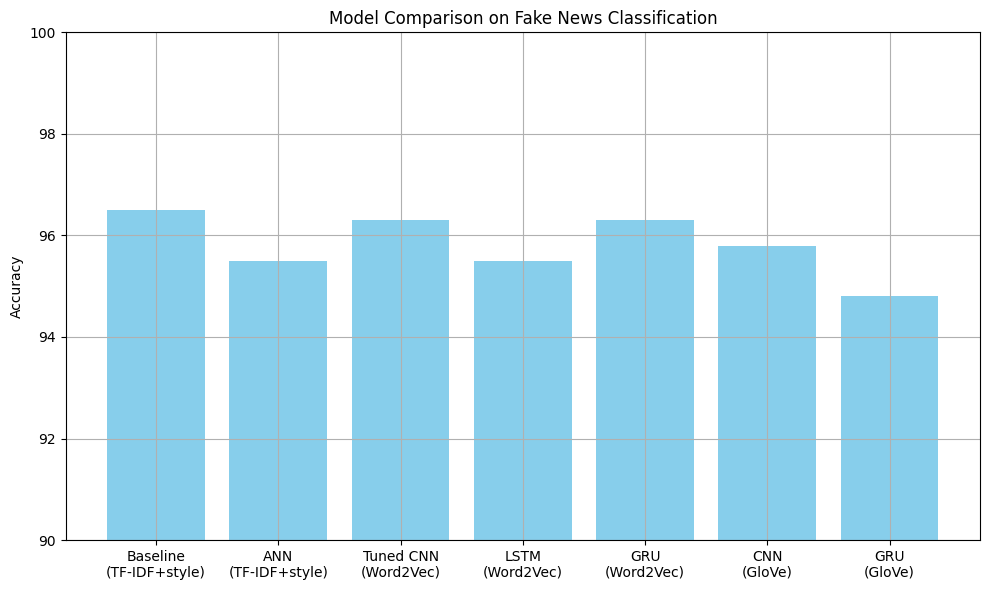

In [20]:
plt.figure(figsize=(10,6))
labels = [
    "Baseline\n(TF-IDF+style)",
    "ANN\n(TF-IDF+style)",
    "Tuned CNN\n(Word2Vec)",
    "LSTM\n(Word2Vec)",
    "GRU\n(Word2Vec)",
    "CNN\n(GloVe)",
    "GRU\n(GloVe)"
]
plt.bar(labels, [np.round(val*100, 1) for val in model_accuracies.values()], color='skyblue')
plt.ylabel("Accuracy")
plt.ylim(90, 100)
plt.title("Model Comparison on Fake News Classification")
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=720)
plt.show()